In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "5"  # Set the GPU 2 to use

In [2]:
import sys

sys.path.append('../GSL')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

import os
from glob import glob, escape
import torch.nn as nn
from torch.nn import functional as F

import pickle
import yaml
from easydict import EasyDict as edict

from torch_geometric.utils import to_dense_adj, dense_to_sparse

In [4]:
from utils.scalers import *
from utils.score import *

In [7]:
exp_dirs = glob('../exp/0729_ECL_EXP/stacks_3__n_head_4__mlp_stack_512_0731_025530')
exp_dirs.sort()

In [8]:
exp_dirs

['../exp/0729_ECL_EXP/stacks_3__n_head_4__mlp_stack_512_0731_025530']

In [9]:
loss_list = []

for exp in exp_dirs:
    test_result_dirs = glob(escape(exp+'/test_result.pickle'))
    if len(test_result_dirs) == 0:
        loss = 100
    else:    
        test_result = pickle.load(open(test_result_dirs[0], 'rb'))
        loss = test_result['score']['scaled_score']['MAE']
    
    loss_list.append(loss)
    
loss_list = np.array(loss_list)

In [10]:
loss_list

array([0.25559947], dtype=float32)

In [11]:
exp = exp_dirs[np.argmin(loss_list)]
# exp = exp_dirs[1]

In [12]:
exp

'../exp/0729_ECL_EXP/stacks_3__n_head_4__mlp_stack_512_0731_025530'

In [13]:
config_file = glob(escape(exp+'/config.yaml'))[0]
config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

train_result_dirs = glob(escape(exp+'/training_result.pickle'))
train_result = pickle.load(open(train_result_dirs[0], 'rb'))

test_result_dirs = glob(escape(exp+'/test_result.pickle'))
test_result = pickle.load(open(test_result_dirs[0], 'rb'))

In [14]:
test_result['score']

{'scaled_score': {'MAE': 0.25559947,
  'MAPE': 0.60961086,
  'RMSE': 0.4111028753447327,
  'MSE': 0.16899557},
 'inv_scaled_score': {'MAE': 222.36829,
  'MAPE': 0.17810963,
  'RMSE': 2221.6169786914215,
  'MSE': 4935582.0}}

In [16]:
test_result.keys()

dict_keys(['per_trend_backcast', 'per_trend_forecast', 'per_seasonality_backcast', 'per_seasonality_forecast', 'singual_backcast', 'singual_forecast', 'test_loss', 'forecast', 'backcast', 'target', 'inputs', 'attention_matrix', 'score'])

In [18]:
target = test_result['target']
pred = test_result['forecast']

inputs = test_result['inputs']
backcast = test_result['backcast']

per_trend_backcast = test_result['per_trend_backcast']
per_trend_forecast = test_result['per_trend_forecast']

per_seasonality_backcast = test_result['per_seasonality_backcast']
per_seasonality_forecast = test_result['per_seasonality_forecast']

singual_backcast = test_result['singual_backcast']
singual_forecast = test_result['singual_forecast']

In [19]:
num_timesteps_in = config.forecasting_module.backcast_length
num_timesteps_out = config.forecasting_module.forecast_length
batch_size = config.train.batch_size
dataset_hyperparameter = f'{num_timesteps_in}_{num_timesteps_out}_{batch_size}'

scaler = pickle.load(
                open(os.path.join(f'../GSL/data/ECL/temporal_signal_{dataset_hyperparameter}.pickle'), 'rb'))
scaler = scaler['scaler']

In [25]:
backcast.shape

(5069, 321, 96)

In [26]:
inv_inputs.shape

(321, 5, 96)

In [27]:
inv_target.shape

(321, 96)

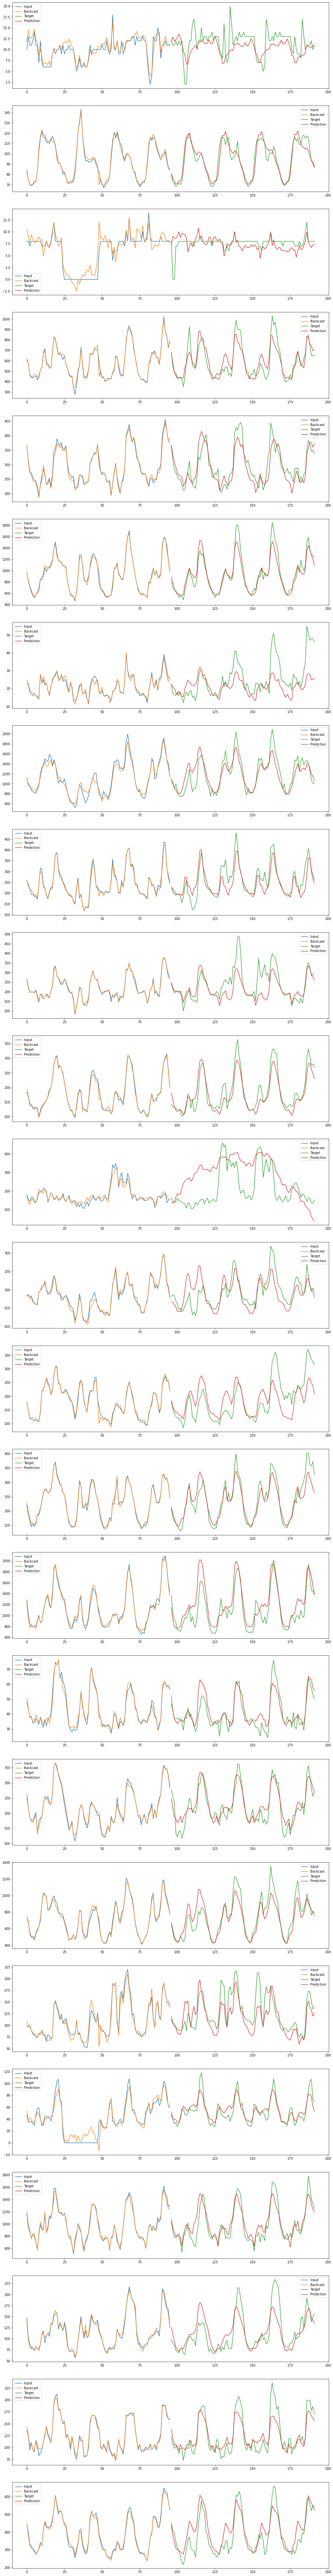

In [28]:
nrow = 25
ncol = 1
batch = -1
node = -3

input_length = config.forecasting_module.backcast_length
output_length = config.forecasting_module.forecast_length

x_axis = np.arange(input_length+output_length)

f, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(18*ncol, 6*nrow), dpi=70)


inv_inputs = scaler.inv_scale(inputs[batch])
inv_backcast = scaler.inv_scale(backcast[batch])
inv_target = scaler.inv_scale(target[batch])
inv_preds = scaler.inv_scale(pred[batch])

for ii in range(nrow):
    axes[ii].plot(x_axis[:input_length], inv_inputs[ii][0], label='Input')
    axes[ii].plot(x_axis[:input_length], inv_backcast[ii], label='Backcast')

    axes[ii].plot(x_axis[input_length:], inv_target[ii], label='Target')
    axes[ii].plot(x_axis[input_length:], inv_preds[ii], label='Prediction')
    axes[ii].legend()

In [31]:
backcast.shape

(5069, 321, 96)

In [32]:
pred.shape

(5069, 321, 96)

In [33]:
nrow

5

In [66]:
inpt.shape

(96,)

In [67]:
interpolate_inputs[0].shape

torch.Size([96])

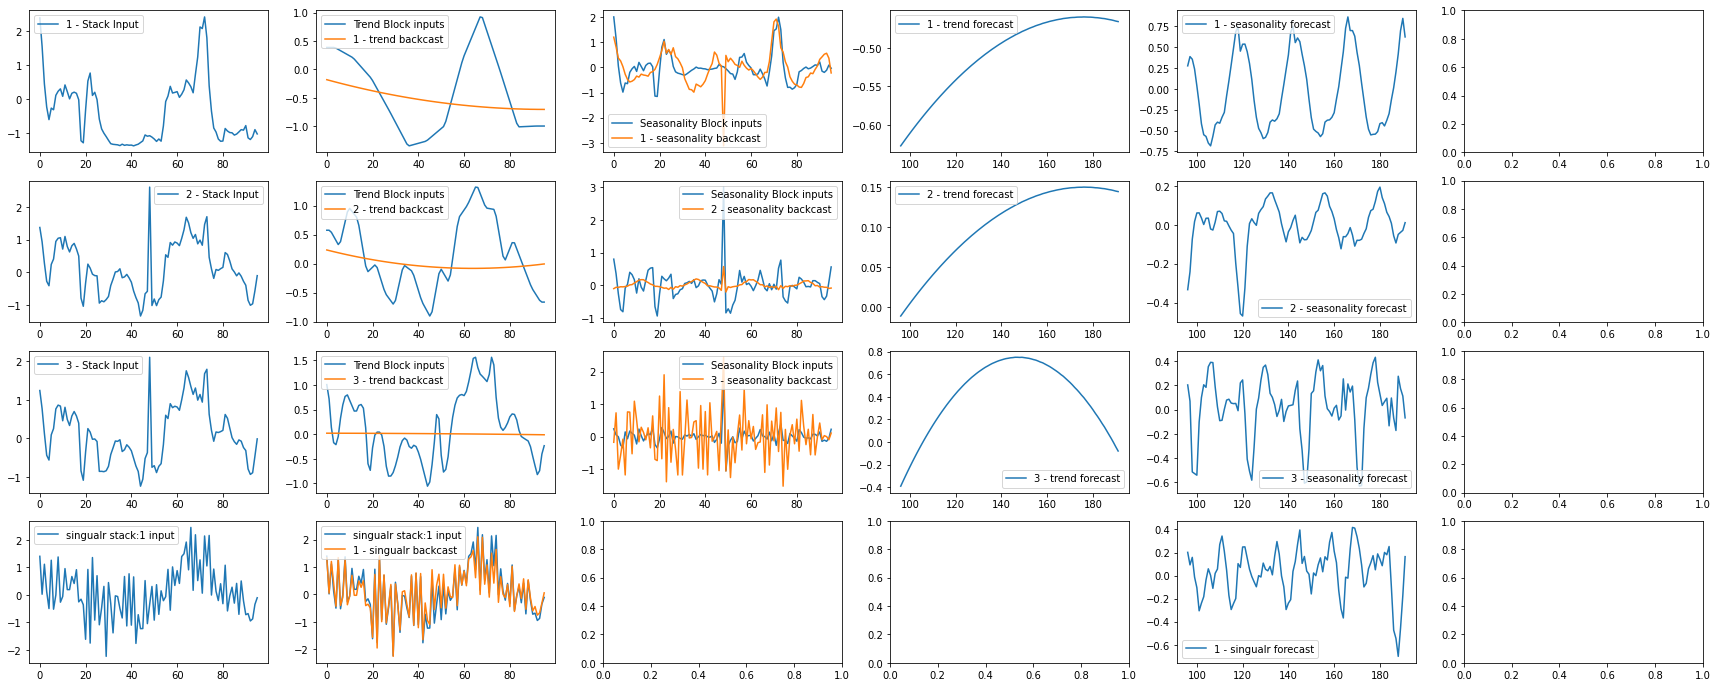

In [71]:
node = -2

nrow = per_trend_backcast.shape[1] + singual_backcast.shape[1]
ncol = 6

input_length = config.forecasting_module.backcast_length
output_length = config.forecasting_module.forecast_length

x_axis = np.arange(input_length+output_length)

f, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(5*ncol, 3*nrow))

inpt = inputs[-1, node, 0]
for ii in range(per_trend_backcast.shape[1]):    
    axes[ii,0].plot(x_axis[:input_length], inpt, label=f'{ii+1} - Stack Input')
    axes[ii,0].legend()
    
    pooling_layer = nn.AvgPool1d(kernel_size=config.forecasting_module.n_pool_kernel_size[ii],
                                              stride=config.forecasting_module.n_pool_kernel_size[ii], 
                                 ceil_mode=False)
    
    pooled_inputs = pooling_layer(torch.Tensor(inpt).unsqueeze(dim=0))

    interpolate_inputs = F.interpolate(pooled_inputs.unsqueeze(dim=1), size=config.forecasting_module.backcast_length,
                                   mode='linear', align_corners=False).squeeze(dim=1)
    
    axes[ii,1].plot(x_axis[:input_length], interpolate_inputs[0], label=f'Trend Block inputs')
    axes[ii,1].legend()
    
        
    axes[ii,2].plot(x_axis[:input_length], inpt-interpolate_inputs[0].numpy(), label=f'Seasonality Block inputs')
    axes[ii,2].legend()
    
    axes[ii,1].plot(x_axis[:input_length], per_trend_backcast[-1,ii][node], label=f'{ii+1} - trend backcast')
    axes[ii,1].legend()
    
    axes[ii,2].plot(x_axis[:input_length], per_seasonality_backcast[-1, ii][node], label=f'{ii+1} - seasonality backcast')
    axes[ii,2].legend()
    
    axes[ii,3].plot(x_axis[input_length:], per_trend_forecast[-1,ii][node], label=f'{ii+1} - trend forecast')
    axes[ii,3].legend()
    
    axes[ii,4].plot(x_axis[input_length:], per_seasonality_forecast[-1, ii][node], label=f'{ii+1} - seasonality forecast')
    axes[ii,4].legend()
    
    inpt = inpt - (per_trend_backcast[-1,ii][node] + per_seasonality_backcast[-1, ii][node])
    
for jj in range(singual_backcast.shape[1]):
    axes[ii+jj+1,0].plot(x_axis[:input_length], inpt, label=f'singualr stack:{jj+1} input')
    axes[ii+jj+1,0].legend()
    
    axes[ii+jj+1,1].plot(x_axis[:input_length], inpt, label=f'singualr stack:{jj+1} input')
    axes[ii+jj+1,1].legend()
    axes[ii+jj+1,1].plot(x_axis[:input_length], singual_backcast[-1,jj][node], label=f'{jj+1} - singualr backcast')
    axes[ii+jj+1,1].legend()
    
    axes[ii+jj+1,4].plot(x_axis[input_length:], singual_forecast[-1,jj][node], label=f'{jj+1} - singualr forecast')
    axes[ii+jj+1,4].legend()
    

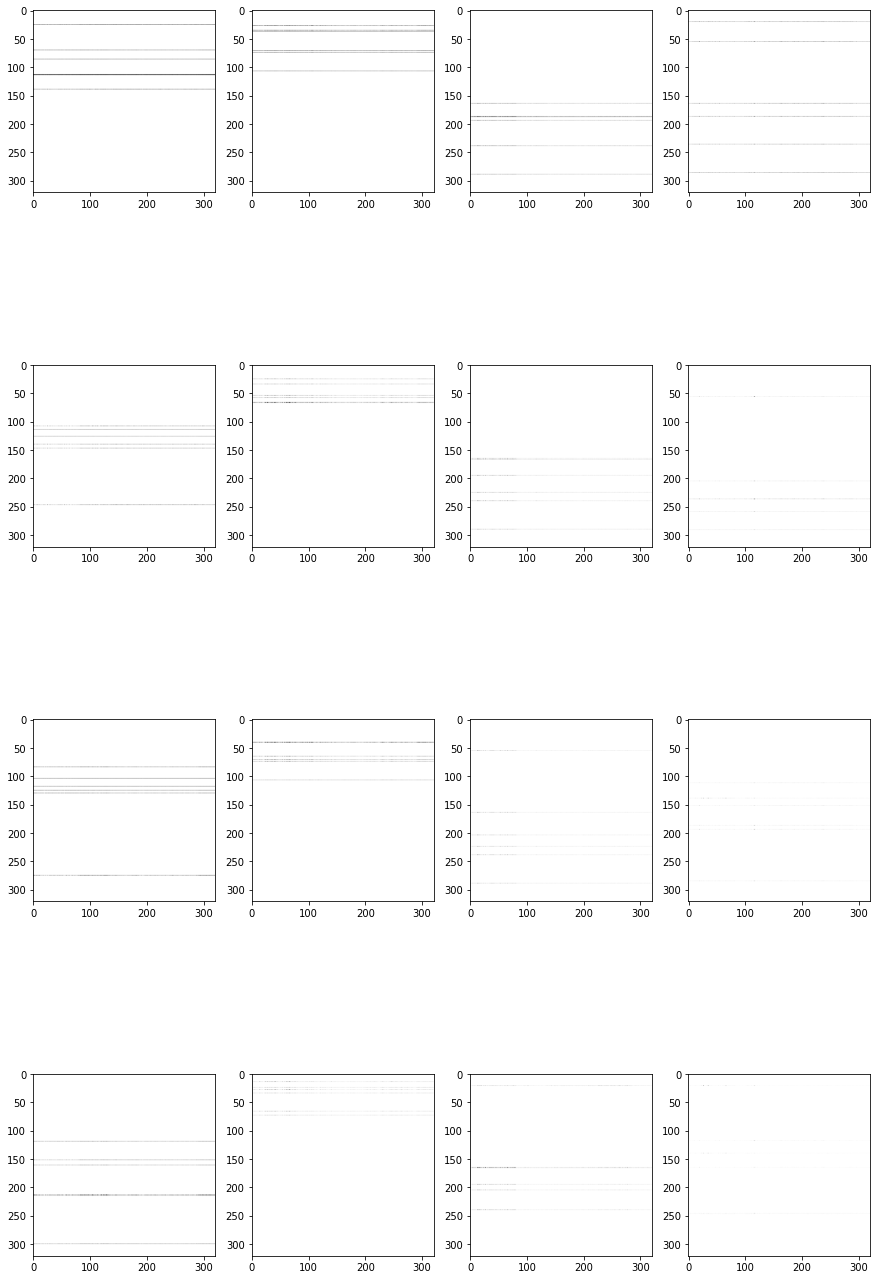

In [64]:
fig, axes = plt.subplots(nrows=config.forecasting_module.stack_num+config.forecasting_module.singular_stack_num, ncols=config.graph_learning.n_head,
                        figsize=(5*ncol, 5*nrow))

for ii in range(config.forecasting_module.stack_num + config.forecasting_module.singular_stack_num):
    for jj in range(config.graph_learning.n_head):
        axes[ii,jj].imshow(test_result['attention_matrix'][-1, ii, 0, jj], cmap='Greys')